# PGA Tour Expected Strokes - Approach

The [Shotlink System](https://shotlink.com/about/history) provides detailed shot-by-shot location data for PGA Tour events, and these data led to many groundbreaking advances in golf analytics. The [strokes gained](http://www.columbia.edu/~mnb2/broadie/Assets/broadie_wscg_v_200804.pdf) metric, a measure of how a golfer's shots compare to an expectation given ball location and other information, headlines these advances.

This notebook contains an effort to replicate the tee shot portion of strokes gained. That is, given the distance of the shot from the hole and its lie, what is the expected number of strokes needed to hole out?

In [49]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import xarray as xr
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
approach_df = pd.read_csv("/content/drive/MyDrive/Golf/approach.csv")
approach_df

,event_id,year,player_id,round_num,hole,distance_val,distance,lie,from,to,type,cup,shotNumber,max_strokes,strokes
0,R2022541,2022,27095,2,18,189.0,189 yds,Primary Rough,ORO,ORO,SST,False,2.0,5.0,4.0
1,R2022540,2022,49117,2,1,158.0,158 yds,Rear Greenside Bunker,OFW,EG8,SST,False,2.0,5.0,4.0
2,R202230,2022,36699,4,4,135.0,135 yds,Left Greenside Bunker,OFW,EG6,SST,False,2.0,4.0,3.0
3,R2022525,2022,54628,3,12,285.0,285 yds,Front Left Greenside Bunker,OFW,EG5,SST,False,2.0,5.0,4.0
4,R202241,2022,51890,2,14,231.0,231 yds,Right Greenside Bunker,OFW,EG2,SST,False,2.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476160,R202247,2022,27129,2,10,87.0,87 yds,Green,OFW,OGR,SST,False,2.0,3.0,2.0
476161,R2021527,2021,22405,1,10,71.0,71 yds,Green,OFW,OGR,SST,False,2.0,3.0,2.0
476162,R202232,2022,36699,2,1,90.0,90 yds,Green,OFW,OGR,SST,False,2.0,3.0,2.0
476163,R202220,2022,46340,4,6,127.0,127 yds,Green,OFW,OGR,SST,False,2.0,3.0,2.0


These data have been filtered and aggregated from the shot-by-shot data. Data cleaning included

*   Removing shots with missing or zero distance from the hole
*   Ensuring each event-year-golfer-round-hole has a tee shot and hole out
*   Removing provisional shots
*   Filtering out tee shots and shots within 50 yards from the hole

For modeling expected strokes, the `distance_val` (the distance of the ball from the hole prior to the shot) and `from` (indicator for the lie before the shot) features are of primary interest. `from` is a bit opaque:



In [3]:
list(set(approach_df["from"]))

['OTH',
 'OWD',
 nan,
 'OST',
 'OGS',
 'OFW',
 'OUK',
 'ORO',
 'OCO',
 'OWA',
 'OIR',
 'ONA',
 'OTO']

Leveraging the full shot dataset and cross-referencing the three-letter codes with the `lie` field yields the following:

*   `'OTH'`: Other
*   `'OWD'`: Water drop area
*   `'OST'`: Fairway bunker
*   `'OGS'`: Greenside bunker
*   `'OFW'`: Fairway
*   `'OUK'`: Unknown
*   `'ORO'`: Primary rough
*   `'OCO'`: Fringe
*   `'OWA'`: Water
*   `'OIR'`: Intermediate rough
*   `'ONA'`: Native area
*   `'OTO'`: Tree outline

Filtering out drops (`type == "SDP"`) leaves just bonafide shots in the dataset

In [9]:
approach_df = approach_df[approach_df["type"]=="SST"]

## Visualization

### Strokes Remaining on Approach

Examining strokes remaining provides a sense of the distribution of the target variable for these types of shots.

In [26]:
stroke_counts = list(approach_df.groupby("strokes")["hole"].count() / len(approach_df))
strokes_remaining = np.arange(1, len(stroke_counts) + 1)

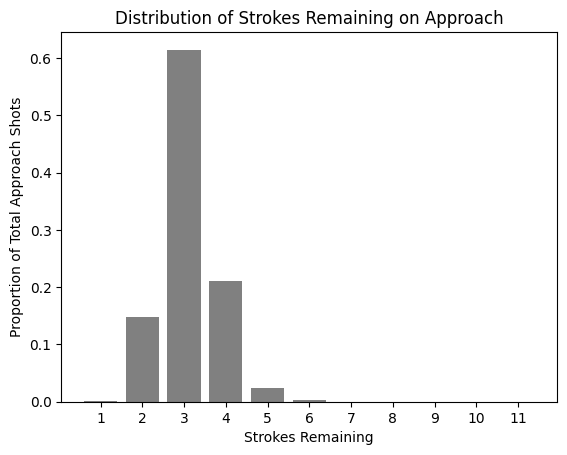

In [24]:
fig, ax = plt.subplots()

# Plot
ax.bar(strokes_remaining, stroke_counts, color="gray")

# Labels
ax.set_xlabel('Strokes Remaining')
ax.set_ylabel('Proportion of Total Approach Shots')
ax.set_title('Distribution of Strokes Remaining on Approach')
ax.set_xticks(strokes_remaining)

plt.show()

Over 60% of approach shots have three strokes remaining, with the vast majority of shots remaining falling between one and six.

## Approach Shots by Lie

Similarly, getting a sense of how lies are distributed across approach shots may be helpful.

In [46]:
lie_dict = {
    "OTH": "Other",
    "OWD": "Water drop area",
    "OST": "Fairway bunker",
    "OGS": "Greenside bunker",
    "OFW": "Fairway",
    "OUK": "Unknown",
    "ORO": "Primary rough",
    "OWA": "Water",
    "OIR": "Intermediate rough",
    "ONA": "Native area",
    "OTO": "Tree outline",
    "OCO": "Fringe"
}

# Find number of shots by lie
lie_df = pd.DataFrame(approach_df.groupby("from")["hole"].count()).reset_index()
lie_df.columns = ["lie", "shots"]

# Human-friendly lie types
lie_df = lie_df.sort_values("shots", ascending=True)
lie_df["lie"] = [lie_dict[x] for x in lie_df["lie"]]

# Proportion of shots
denom = np.sum(lie_df["shots"])
lie_df["shots"] /= denom

lie_df

,lie,shots
0,Fringe,0.000004
9,Unknown,0.000004
8,Tree outline,0.000013
10,Water,0.000083
2,Greenside bunker,0.000752
11,Water drop area,0.002775
7,Other,0.016576
4,Native area,0.019173
6,Fairway bunker,0.052494
3,Intermediate rough,0.056937


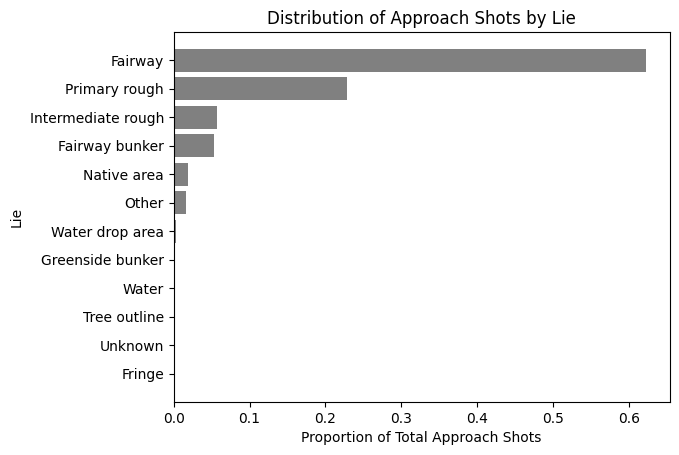

In [47]:
fig, ax = plt.subplots()

# Plot
ax.barh(np.arange(len(lie_df)), lie_df["shots"], color="gray")

# Labels
ax.set_ylabel('Lie')
ax.set_xlabel('Proportion of Total Approach Shots')
ax.set_title('Distribution of Approach Shots by Lie')
ax.set_yticks(np.arange(len(lie_df)))
ax.set_yticklabels(list(lie_df["lie"]))

plt.show()

Approach shots are dominated by fairway lies, followed by a list of usual suspects.

## Expected Strokes by Lie and Distance

Since the model will consider lie, examining the effect of both lie and distance together might indicate which modeling choices to make.

In [82]:
# Subset DataFrame to just consider fairway, rough, and bunker shots
type_df = approach_df[approach_df["from"].isin(["OFW", "ORO", "OIR", "OST", "OGS"])].copy()
type_df["lie"] = ["Fairway" if x == "OFW" else
                  "Rough" if x in ["ORO", "OIR"] else
                  "Bunker" for x in type_df["from"]]

# Initialize discretizer
fairway_est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile', subsample=None)
rough_est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile', subsample=None)
bunker_est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile', subsample=None)

# Subset again
fairway_df = type_df[type_df["lie"]=="Fairway"].copy()
rough_df = type_df[type_df["lie"]=="Rough"].copy()
bunker_df = type_df[type_df["lie"]=="Bunker"].copy()

# Fit and transform to bins
fairway_bin = fairway_est.fit_transform(fairway_df[["distance_val"]])
rough_bin = rough_est.fit_transform(rough_df[["distance_val"]])
bunker_bin = bunker_est.fit_transform(bunker_df[["distance_val"]])

# Store
fairway_df["bin"] = [x[0] for x in fairway_bin]
rough_df["bin"] = [x[0] for x in rough_bin]
bunker_df["bin"] = [x[0] for x in bunker_bin]

In [83]:
fw_viz = pd.DataFrame(fairway_df.groupby("bin")["distance_val", "strokes"].mean()).reset_index()
ro_viz = pd.DataFrame(rough_df.groupby("bin")["distance_val", "strokes"].mean()).reset_index()
bu_viz = pd.DataFrame(bunker_df.groupby("bin")["distance_val", "strokes"].mean()).reset_index()

<ipython-input-83-56bfd149fc98>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  fw_viz = pd.DataFrame(fairway_df.groupby("bin")["distance_val", "strokes"].mean()).reset_index()
<ipython-input-83-56bfd149fc98>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ro_viz = pd.DataFrame(rough_df.groupby("bin")["distance_val", "strokes"].mean()).reset_index()
<ipython-input-83-56bfd149fc98>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bu_viz = pd.DataFrame(bunker_df.groupby("bin")["distance_val", "strokes"].mean()).reset_index()


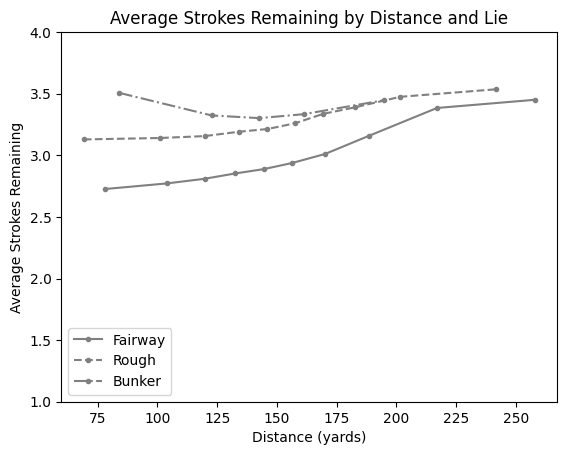

In [90]:
fig, ax = plt.subplots()

# Plot
## Fairway
ax.plot(
        fw_viz["distance_val"], fw_viz["strokes"],
        linestyle='-', marker='o', markersize=3,
        color='gray', label="Fairway"
    )
## Fairway
ax.plot(
        ro_viz["distance_val"], ro_viz["strokes"],
        linestyle='--', marker='o', markersize=3,
        color='gray', label="Rough"
    )
## Bunker
ax.plot(
        bu_viz["distance_val"], bu_viz["strokes"],
        linestyle='-.', marker='o', markersize=3,
        color='gray', label="Bunker"
    )

# Labels
ax.set_xlabel('Distance (yards)')
ax.set_ylabel('Average Strokes Remaining')
ax.set_title('Average Strokes Remaining by Distance and Lie')
ax.legend()
ax.set_ylim(1, 4)

plt.show()

Several patterns jump out from the above:

*   At shorter distances, a shot from the fairway offers about a half stroke advantage over shots from the rough and almost a full stroke advantage from bunker shots
*   That gap narrows between lie types as distance from the hole increases
*   Bunker shots from shorter distances appear to be the most difficult shot type. Perhaps, at intermediate distances on approach, bunker shots are more difficult to control. The difficulty of bunker shots and shots from the rough converge at around 150 yards from the hole



